In [71]:
import numpy as np, pandas as pd
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim, torch.utils.data as data_utils, torch
import my_metric as mm
from torch.utils.data.sampler import SubsetRandomSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data

In [103]:
all_X = pd.read_pickle('../data/pokec_cleaned/profs_all.pkl')
agg_X = pd.read_pickle('../data/pokec_cleaned/profs_agg.pkl')
Y = pd.read_pickle('../data/pokec_cleaned/profs_Y.pkl')

In [104]:
all_X = all_X.drop(['age'], axis=1).set_index('user_id')

In [105]:
all_X.head(3)

,gender,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
user_id,,,,,,,,,,,,,,,,,,,,,
16,1.0,0.048036,0.033103,0.021765,-0.015159,0.044825,0.018631,0.040076,-0.014536,0.031466,...,0.10062,-0.014866,0.047434,0.00729,-0.012358,-0.005653,-0.010456,-0.000368,-0.038143,0.063126
32,1.0,0.138977,0.014836,0.054817,0.110309,0.056415,0.091919,0.064899,0.000000,0.045998,...,0.11366,0.000000,0.054221,0.00998,0.019479,0.007750,0.006421,0.000000,0.005256,0.049405
46,0.0,0.122002,0.138915,0.026357,0.108986,0.033561,0.011236,0.078515,0.000000,0.051494,...,0.00000,0.017397,0.023455,0.00000,0.024935,0.000000,0.000000,0.088059,0.000000,0.022983


### View distribution of ages

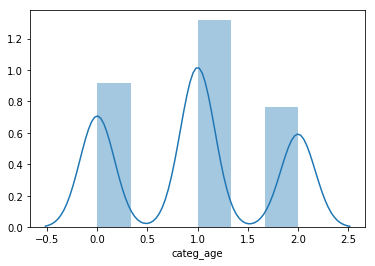

In [106]:
ax = sns.distplot(Y.categ_age)

In [107]:
Y.categ_age.value_counts(normalize=True)

1    0.438630
0    0.305556
2    0.255814
Name: categ_age, dtype: float64

### Convert categ_age vector to one-hot vector

In [108]:
Y_values = Y.categ_age.values
Y_len = Y_values.shape[0]

In [109]:
Y_oh = np.zeros((Y_len, 3))
Y_oh[np.arange(Y_len), Y_values] = 1

### Split into train and test variables

In [110]:
X_train, X_test, y_train, y_test = train_test_split(all_X, Y_oh, test_size=0.15, random_state=42)

### Convert to tensors

In [10]:
features = torch.from_numpy(agg_X.values)
targets = torch.from_numpy(Y_values)

In [11]:
dataset = data_utils.TensorDataset(features, targets)

In [12]:
batch_size = 100
validation_split = .2
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = features.size()[0]
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

### Define neural network, optimizer, and loss objects

In [111]:
n_in = all_X.shape[1]
n_h = 512
n_out = 3
model = nn.Sequential(nn.Linear(n_in, n_h), 
                      nn.ReLU(), 
                      nn.Linear(n_h, n_out), 
                      nn.Softmax(dim=1))

optimizer = optim.SGD(params=model.parameters(), lr=0.5, momentum=0.9)
criterion = nn.CrossEntropyLoss()#reduction=False)

### Training loop

In [21]:
epochs = 20

for epoch in range(epochs):
    for batch_index, data in enumerate(train_loader):
        local_batch, local_labels = data
        # Forward Propagation
        y_pred = model(local_batch.float())
        # Compute and print loss
        loss = criterion(y_pred, local_labels.long())
        print('epoch: ', epoch ,'batch: ', batch_index, ' loss: ', loss.item())
        # Zero the gradients
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()
#     with torch.set_grad_enabled(False):
#         for local_batch, local_labels in validation_loader:
#             y_pred = model(local_batch.float())
#             print("in validation block of code")

epoch:  0 batch:  0  loss:  1.0206522941589355
epoch:  0 batch:  1  loss:  1.0969254970550537
epoch:  0 batch:  2  loss:  1.0500922203063965
epoch:  0 batch:  3  loss:  1.142055630683899
epoch:  0 batch:  4  loss:  1.0797786712646484
epoch:  0 batch:  5  loss:  1.161199688911438
epoch:  0 batch:  6  loss:  1.136264681816101
epoch:  0 batch:  7  loss:  1.181401014328003
epoch:  0 batch:  8  loss:  1.1114013195037842
epoch:  0 batch:  9  loss:  1.081444263458252
epoch:  0 batch:  10  loss:  1.1914401054382324
epoch:  0 batch:  11  loss:  1.0814369916915894
epoch:  0 batch:  12  loss:  1.0129854679107666
epoch:  1 batch:  0  loss:  1.062666893005371
epoch:  1 batch:  1  loss:  1.1514427661895752
epoch:  1 batch:  2  loss:  1.121444821357727
epoch:  1 batch:  3  loss:  1.0621634721755981
epoch:  1 batch:  4  loss:  1.0714095830917358
epoch:  1 batch:  5  loss:  1.1414449214935303
epoch:  1 batch:  6  loss:  1.0814436674118042
epoch:  1 batch:  7  loss:  1.0214449167251587
epoch:  1 batch: 

### Keras implementation

In [142]:
kmodel = Sequential()
kmodel.add(Dense(n_h, input_dim=n_in, activation='relu'))
kmodel.add(Dropout(0.6, name='dropout_1'))
kmodel.add(Dense(n_out, activation='softmax'))

In [143]:
my_met = mm.Metrics()

In [144]:
kmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#, callbacks=[my_met])

In [145]:
history = kmodel.fit(X_train, y_train, validation_split=.15, epochs=5, batch_size=30)

Train on 1117 samples, validate on 198 samples
Epoch 1/5
1117/1117 [==============================] - 2s 2ms/step - loss: 1.1062 - acc: 0.4056 - val_loss: 1.0612 - val_acc: 0.4242
Epoch 2/5
1117/1117 [==============================] - 2s 1ms/step - loss: 1.0291 - acc: 0.4700 - val_loss: 1.0726 - val_acc: 0.4192
Epoch 3/5
1117/1117 [==============================] - 2s 1ms/step - loss: 1.0025 - acc: 0.5004 - val_loss: 1.0394 - val_acc: 0.4444
Epoch 4/5
1117/1117 [==============================] - 2s 1ms/step - loss: 0.9954 - acc: 0.5175 - val_loss: 0.9985 - val_acc: 0.4545
Epoch 5/5
1117/1117 [==============================] - 2s 1ms/step - loss: 0.9676 - acc: 0.5255 - val_loss: 0.9754 - val_acc: 0.4899


In [146]:
# evaluate the model
scores = kmodel.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (kmodel.metrics_names[1], scores[1]*100))

233/233 [==============================] - 0s 275us/step

acc: 50.21%


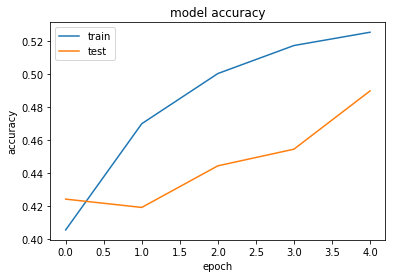

In [147]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()